In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import zipfile
from io import BytesIO

In [17]:
# === Config ===
zip_path = r"D:\Zotero\storage\QVWE4F35\Risultati_per_Italia_Luglio_2025.zip"
excel_name = "Risultati per l'Italia indice di diffusione (ultimo agg.to - Luglio 2025).xlsx"


In [8]:
with zipfile.ZipFile(zip_path) as z:
    with z.open(excel_filename) as f:
        xls = pd.ExcelFile(f)
        print(xls.sheet_names)


['Nota Esplicativa ', 'Dom. 1 e 8', 'Dom. 2 ', 'Dom. 3', 'Dom. 4', 'Dom. 5', 'Dom. 6 e 9', 'Dom. 7', 'Dom. 10 e 21', 'Dom. 11', 'Dom. 12', 'Dom. 13', 'Dom. 14', 'Dom. 15', 'Dom. 16', 'Dom. 17', 'Dom. 18 e 22', 'Dom. 19', 'Dom. 20', 'Raccordo domande e voci', 'Dom. AD HOC']


## Domanda

C:\Users\paolo\AppData\Local\Temp\ipykernel_27280\2186278536.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Anno"] = pd.to_numeric(df["Anno"], errors="coerce").fillna(method="ffill")
C:\Users\paolo\AppData\Local\Temp\ipykernel_27280\2186278536.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Anno"] = pd.to_numeric(df["Anno"], errors="coerce").fillna(method="ffill")
C:\Users\paolo\AppData\Local\Temp\ipykernel_27280\2186278536.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Anno"] = pd.to_numeric(df["Anno"], errors="coerce").fillna(method="ffill")
C:\Users\paolo\AppData\Local\Temp\ipykernel_27280\2186278536.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future ve

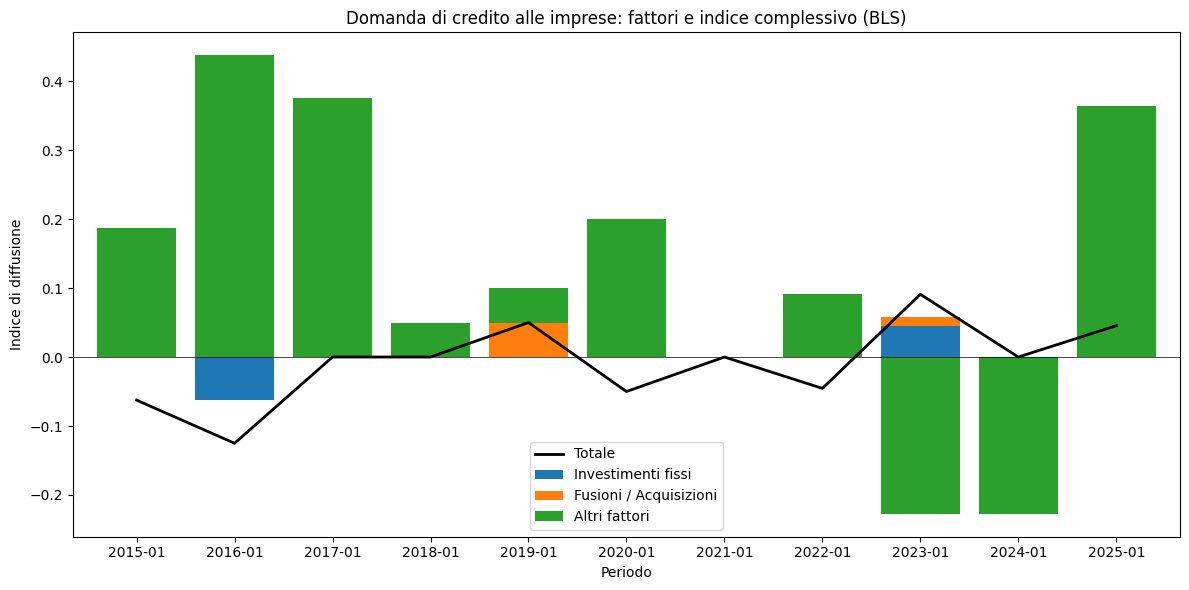

In [11]:
# === Mappa mesi ===
mesi_map = {
    "Gennaio": "01", "Febbraio": "02", "Marzo": "03", "Aprile": "04",
    "Maggio": "05", "Giugno": "06", "Luglio": "07", "Agosto": "08",
    "Settembre": "09", "Ottobre": "10", "Novembre": "11", "Dicembre": "12"
}

# === Fogli domanda per fattore ===
fogli_domanda = {
    "Investimenti fissi": "Dom. 11",
    "Scorte e capitale circolante": "Dom. 12",
    "Tassi di interesse": "Dom. 13",
    "Fusioni / Acquisizioni": "Dom. 14",
    "Autofinanziamento": "Dom. 15",
    "Fonti alternative": "Dom. 16",
    "Rifinanziamento / ristrutturazione": "Dom. 17",
    "Altri fattori": "Dom. 18 e 22"
}

# === Lettura dei fattori ===
fattori_domanda_df = {}

with zipfile.ZipFile(zip_path) as z:
    for nome_fattore, sheet in fogli_domanda.items():
        with z.open(excel_filename) as f:
            df = pd.read_excel(f, sheet_name=sheet, skiprows=6)
            df = df.rename(columns={df.columns[0]: "Anno", df.columns[1]: "Mese"})
            df = df[df["Anno"].notna()]
            df["Anno"] = pd.to_numeric(df["Anno"], errors="coerce").fillna(method="ffill")
            df["Mese_num"] = df["Mese"].map(mesi_map)
            df["Periodo"] = pd.to_datetime(df["Anno"].astype(int).astype(str) + "-" + df["Mese_num"] + "-01", errors="coerce")
            
            # Colonna valore effettiva
            col_val = df.columns[2]
            if df[col_val].notna().sum() > 0:
                df = df[["Periodo", col_val]].rename(columns={col_val: nome_fattore})
                fattori_domanda_df[nome_fattore] = df

# === Merge dei fattori ===
df_domanda_stack = reduce(lambda left, right: pd.merge(left, right, on="Periodo", how="outer"), fattori_domanda_df.values())
df_domanda_stack = df_domanda_stack[df_domanda_stack["Periodo"].dt.year >= 2015].sort_values("Periodo")
df_domanda_stack.set_index("Periodo", inplace=True)

# === Totale domanda: Domanda 10 ===
with zipfile.ZipFile(zip_path) as z:
    with z.open(excel_filename) as f:
        df_totale = pd.read_excel(f, sheet_name="Dom. 10 e 21", skiprows=6)
        df_totale = df_totale.rename(columns={df_totale.columns[0]: "Anno", df_totale.columns[1]: "Mese"})
        df_totale = df_totale[df_totale["Anno"].notna()]
        df_totale["Anno"] = pd.to_numeric(df_totale["Anno"], errors="coerce").fillna(method="ffill")
        df_totale["Mese_num"] = df_totale["Mese"].map(mesi_map)
        df_totale["Periodo"] = pd.to_datetime(df_totale["Anno"].astype(int).astype(str) + "-" + df_totale["Mese_num"] + "-01", errors="coerce")
        df_totale = df_totale[["Periodo", df_totale.columns[2]]].rename(columns={df_totale.columns[2]: "Totale"})


# === Merge finale + plot ===
df_domanda = df_domanda_stack.merge(df_totale, on="Periodo", how="left").set_index("Periodo")
componenti = df_domanda.drop(columns="Totale")
totale = df_domanda["Totale"]

# Indice leggibile
componenti.index = componenti.index.strftime("%Y-%m")
totale.index = componenti.index  # allineamento

# === Grafico ===
ax = componenti.plot(kind="bar", stacked=True, figsize=(12, 6), width=0.8, legend=False)
totale.plot(ax=ax, color="black", label="Totale", linewidth=2)
plt.title("Domanda di credito alle imprese: fattori e indice complessivo (BLS)")
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel("Indice di diffusione")
plt.legend()
plt.tight_layout()
plt.show()



IndexError: index 0 is out of bounds for axis 0 with size 0

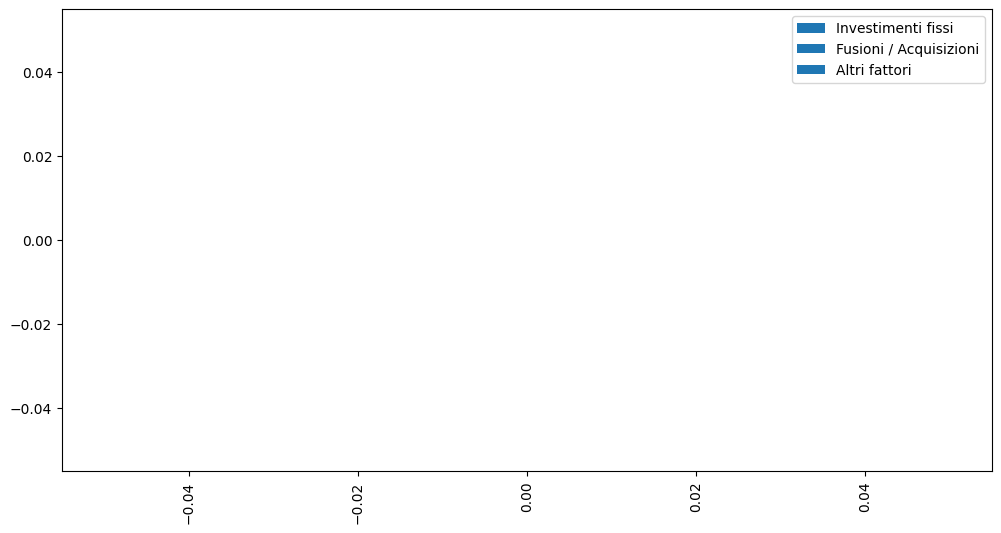

In [19]:
# === Mappa dei fogli da leggere: nome_fattore -> nome foglio ===
fogli_domanda = {
    "Investimenti fissi": "Dom. 11",
    "Scorte e capitale circolante": "Dom. 12",
    "Tassi di interesse": "Dom. 13",
    "Fusioni / Acquisizioni": "Dom. 14",
    "Autofinanziamento": "Dom. 15",
    "Fonti alternative": "Dom. 16",
    "Rifinanziamento / ristrutturazione": "Dom. 17",
    "Altri fattori": "Dom. 18 e 22"
}

# === Lettura dei fogli della domanda ===
with zipfile.ZipFile(zip_path) as zf:
    with zf.open(excel_name) as f:
        xls = pd.ExcelFile(f)
        fattori_domanda_df = {}

        for nome_fattore, sheet in fogli_domanda.items():
            df = pd.read_excel(xls, sheet_name=sheet, skiprows=6)
            df = df.rename(columns={df.columns[0]: "Anno", df.columns[1]: "Mese", df.columns[2]: nome_fattore})

            # Filtra righe valide
            df = df[pd.to_numeric(df["Anno"], errors="coerce").notna() & pd.to_numeric(df["Mese"], errors="coerce").notna()]
            df["Anno"] = df["Anno"].astype(int)
            df["Mese"] = df["Mese"].astype(int)

            df["Periodo"] = pd.to_datetime(df["Anno"].astype(str) + "-" + df["Mese"].astype(str))
            fattori_domanda_df[nome_fattore] = df[["Periodo", nome_fattore]]

# === Merge su 'Periodo' ===
df_domanda_stack = reduce(lambda left, right: pd.merge(left, right, on="Periodo", how="outer"), fattori_domanda_df.values())
df_domanda_stack = df_domanda_stack[df_domanda_stack["Periodo"].dt.year >= 2015].sort_values("Periodo")
df_domanda_stack.set_index("Periodo", inplace=True)

# === Indice totale e previsto ===
with zipfile.ZipFile(zip_path) as zf:
    with zf.open(excel_name) as f:
        xls = pd.ExcelFile(f)
        totale_df = pd.read_excel(xls, sheet_name="Dom. 10 e 21", skiprows=6)
        totale_df = totale_df.rename(columns={totale_df.columns[0]: "Anno", totale_df.columns[1]: "Mese"})

        totale_df = totale_df[pd.to_numeric(totale_df["Anno"], errors="coerce").notna() & pd.to_numeric(totale_df["Mese"], errors="coerce").notna()]
        totale_df["Anno"] = totale_df["Anno"].astype(int)
        totale_df["Mese"] = totale_df["Mese"].astype(int)

        totale_df["Periodo"] = pd.to_datetime(totale_df["Anno"].astype(str) + "-" + totale_df["Mese"].astype(str))
        totale_df = totale_df[["Periodo", totale_df.columns[2], totale_df.columns[3]]]
        totale_df.columns = ["Periodo", "Totale", "Previsto"]
        totale_df = totale_df[totale_df["Periodo"].dt.year >= 2015].set_index("Periodo")

# === Plot ===
fig, ax = plt.subplots(figsize=(12, 6))

# Barre stacked
df_domanda_stack.plot(kind="bar", stacked=True, ax=ax, width=0.9)

# Linea indice effettivo
totale_df["Totale"].plot(ax=ax, color="black", linewidth=2, label="Indice di domanda effettivo")

# Punto previsto
ax.scatter(totale_df.index[-1], totale_df["Previsto"].iloc[-1], color="red", s=40, label="Indice di domanda previsto", zorder=5)

# Layout
ax.set_title("Domanda di credito alle imprese: fattori e indice complessivo (BLS)")
ax.set_ylabel("Indice di diffusione")
ax.axhline(0, color="grey", linewidth=0.8)
ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()


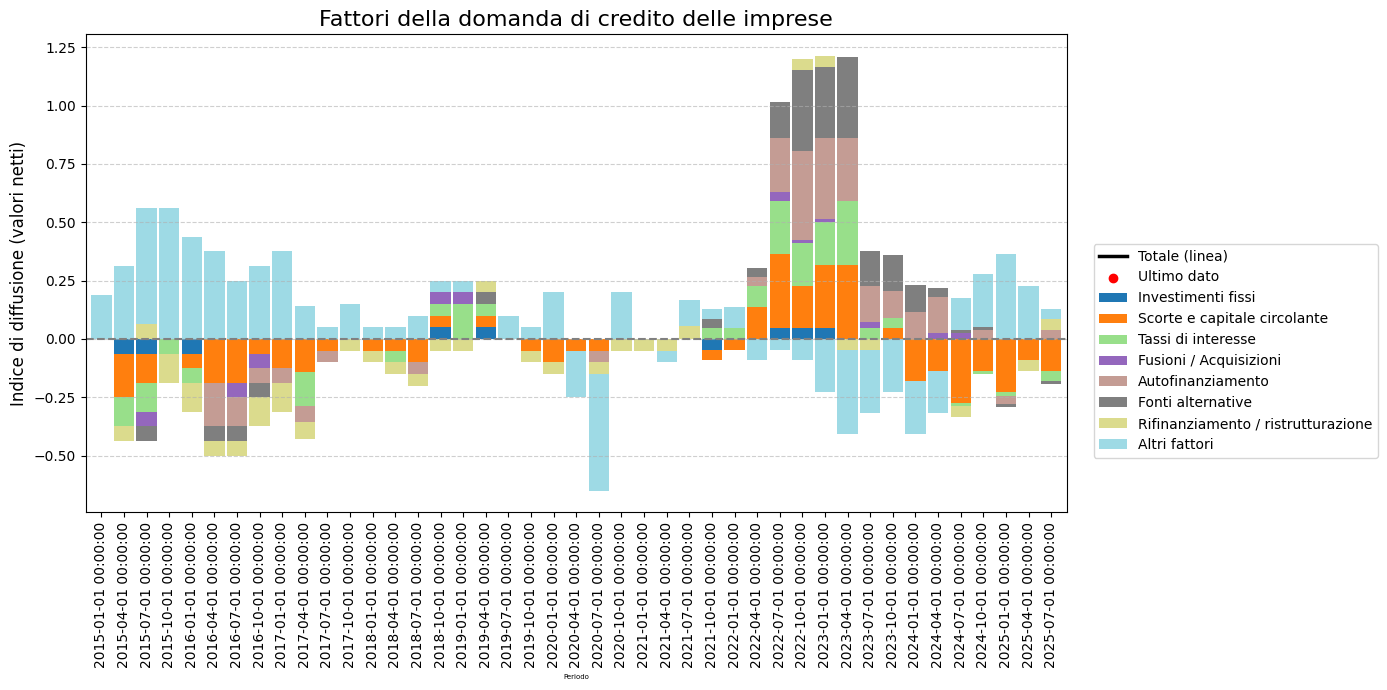

In [26]:

# === Mappatura fogli-fattori (colonna 3 di ciascun foglio)
fogli_domanda = {
    "Investimenti fissi": "Dom. 11",
    "Scorte e capitale circolante": "Dom. 12",
    "Tassi di interesse": "Dom. 13",
    "Fusioni / Acquisizioni": "Dom. 14",
    "Autofinanziamento": "Dom. 15",
    "Fonti alternative": "Dom. 16",
    "Rifinanziamento / ristrutturazione": "Dom. 17",
    "Altri fattori": "Dom. 18 e 22"
}

# === Mappatura mesi
mesi_mapping = {
    "Gennaio": 1, "Febbraio": 2, "Marzo": 3,
    "Aprile": 4, "Maggio": 5, "Giugno": 6,
    "Luglio": 7, "Agosto": 8, "Settembre": 9,
    "Ottobre": 10, "Novembre": 11, "Dicembre": 12
}

# === Estrazione e parsing dei dati
fattori_domanda_df = {}

with zipfile.ZipFile(zip_path) as zf:
    with zf.open(excel_name) as f:
        xls = pd.ExcelFile(f)
        for nome_fattore, sheet in fogli_domanda.items():
            df = pd.read_excel(xls, sheet_name=sheet, skiprows=6)
            df = df.rename(columns={df.columns[0]: "Anno", df.columns[1]: "Mese", df.columns[2]: nome_fattore})
            df["Anno"] = df["Anno"].ffill()  # Propaga in avanti l’anno
            df = df[df["Mese"].isin(mesi_mapping.keys())]
            df["Mese"] = df["Mese"].map(mesi_mapping)
            df["Periodo"] = pd.to_datetime(df["Anno"].astype(int).astype(str) + "-" + df["Mese"].astype(int).astype(str))
            fattori_domanda_df[nome_fattore] = df[["Periodo", nome_fattore]]

# === Merge di tutti i fattori su 'Periodo'
df_domanda_stack = reduce(lambda left, right: pd.merge(left, right, on="Periodo", how="outer"), fattori_domanda_df.values())
df_domanda_stack = df_domanda_stack[df_domanda_stack["Periodo"].dt.year >= 2015].sort_values("Periodo")
df_domanda_stack.set_index("Periodo", inplace=True)

# === Pulizia: sostituisci '-' con NaN e conversione numerica
for col in df_domanda_stack.columns:
    df_domanda_stack[col] = pd.to_numeric(df_domanda_stack[col].replace("-", pd.NA), errors="coerce")

# === Calcolo Totale
df_domanda_stack["Totale"] = df_domanda_stack.sum(axis=1)

# === Plot
plt.figure(figsize=(14, 7))
df_domanda_stack.drop(columns="Totale").plot(kind="bar", stacked=True, width=0.9, ax=plt.gca(), colormap="tab20")
plt.plot(df_domanda_stack.index, df_domanda_stack["Totale"], color="black", linewidth=2.5, label="Totale (linea)")
plt.scatter(df_domanda_stack.index[-1], df_domanda_stack["Totale"].iloc[-1], color="red", zorder=5, label="Ultimo dato")

plt.title("Fattori della domanda di credito delle imprese", fontsize=16)
plt.ylabel("Indice di diffusione (valori netti)", fontsize=12)
plt.xlabel("Periodo", fontsize=5)
plt.xticks()
plt.axhline(0, color="grey", linestyle="--")
plt.legend(loc="lower left", bbox_to_anchor=(1.02, 0.1))
plt.tight_layout()
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.show()


In [28]:
with zipfile.ZipFile(zip_path, 'r') as z:
    with z.open(excel_filename) as file:
        xls_bytes = BytesIO(file.read())

xls = pd.ExcelFile(xls_bytes)

# === 2. Definisci i fogli da leggere per i fattori della domanda ===
fogli_domanda = {
    "Investimenti fissi": "Dom. 2 ",
    "Scorte e capitale circolante": "Dom. 3",
    "Tassi di interesse": "Dom. 4",
    "Fusioni / Acquisizioni": "Dom. 5",
    "Autofinanziamento": "Dom. 6 e 9",
    "Fonti alternative": "Dom. 10 e 21",
    "Rifinanziamento / ristrutturazione": "Dom. 11",
    "Altri fattori": "Dom. 12"
}

# === 3. Estrai e pulisci i dati ===
fattori_domanda_df = {}

for nome_fattore, sheet in fogli_domanda.items():
    df = pd.read_excel(xls, sheet_name=sheet, skiprows=6)
    df = df.rename(columns={df.columns[0]: "Anno", df.columns[1]: "Mese", df.columns[2]: nome_fattore})
    df = df[df["Anno"].apply(lambda x: isinstance(x, (int, float)))]
    df["Anno"] = pd.to_numeric(df["Anno"], errors="coerce")
    df["Mese"] = pd.to_numeric(df["Mese"], errors="coerce")
    df[nome_fattore] = pd.to_numeric(df[nome_fattore], errors="coerce")
    df["Periodo"] = pd.to_datetime(df["Anno"].astype(int).astype(str) + "-" + df["Mese"].astype(int).astype(str), errors='coerce')
    fattori_domanda_df[nome_fattore] = df[["Periodo", nome_fattore]].dropna()

# === 4. Merge dei DataFrame ===
df_domanda_stack = reduce(lambda left, right: pd.merge(left, right, on="Periodo", how="outer"), fattori_domanda_df.values())
df_domanda_stack = df_domanda_stack[df_domanda_stack["Periodo"].dt.year >= 2015].sort_values("Periodo")
df_domanda_stack.set_index("Periodo", inplace=True)
df_domanda_stack["Totale"] = df_domanda_stack.mean(axis=1, skipna=True)

# === 5. Plot: stacked bar + linea ===
plt.figure(figsize=(14, 7))
cols_fattori = [col for col in df_domanda_stack.columns if col != "Totale"]

# Stacked bar
df_domanda_stack[cols_fattori].plot(kind="bar", stacked=True, width=0.9, ax=plt.gca(), colormap="tab20")

# Linea del totale
plt.plot(df_domanda_stack.index, df_domanda_stack["Totale"], color="black", linewidth=2.5, label="Totale (linea)")
plt.scatter(df_domanda_stack.index[-1], df_domanda_stack["Totale"].iloc[-1], color="red", zorder=5, label="Ultimo dato")

# Asse x con solo l'anno (gennaio)
x_ticks = [d for d in df_domanda_stack.index if d.month == 1]
x_labels = [str(d.year) for d in x_ticks]
plt.xticks(x_ticks, x_labels, rotation=0)

plt.title("Fattori della domanda di credito alle imprese", fontsize=16)
plt.ylabel("Indice di diffusione (valori netti)", fontsize=12)
plt.xlabel("Anno", fontsize=12)
plt.axhline(0, color="grey", linestyle="--")
plt.legend(loc="lower left", bbox_to_anchor=(1.02, 0.1))
plt.tight_layout()
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.show()


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer